In [1]:
import os
os.chdir("/Users/Owner/OneDrive/Desktop/")

In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from dataset import CustomEmotionDataset

#from scipy.misc import imread, imresize

%matplotlib inline

# PyTorch

In [3]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm



print(f"Torch: {torch.__version__}")

Torch: 2.2.2+cu118


In [4]:
# Training settings
batch_size = 64 #48# 32# 32 #16 #8 #
epochs = 40
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [5]:
USE_ENET2=True #False #

In [6]:
IMG_SIZE=260 if USE_ENET2 else 224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
print(test_transforms)

Compose(
    Resize(size=(260, 260), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

# Multi-task: FER+Valence-Arousal 

In [8]:
affectnet_expr2emotion={0:'Neutral',1:'Happiness', 2:'Sadness', 3:'Surprise', 4:'Fear', 5:'Disgust', 6:'Anger'}# , 7:'Contempt'}
# idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
idx_to_class={0:'Neutral',1:'Happiness', 2:'Sadness', 3:'Surprise', 4:'Fear', 5:'Disgust', 6:'Anger'}
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}


In [9]:
def ConcordanceCorCoeff(prediction, ground_truth):
    mean_gt = torch.mean (ground_truth, 0)
    mean_pred = torch.mean (prediction, 0)
    var_gt = torch.var (ground_truth, 0)
    var_pred = torch.var (prediction, 0)
    v_pred = prediction - mean_pred
    v_gt = ground_truth - mean_gt
    cor = torch.sum (v_pred * v_gt) / (torch.sqrt(torch.sum(v_pred ** 2)) * torch.sqrt(torch.sum(v_gt ** 2)))
    sd_gt = torch.std(ground_truth)
    sd_pred = torch.std(prediction)
    numerator=2*cor*sd_gt*sd_pred
    denominator=var_gt+var_pred+(mean_gt-mean_pred)**2
    ccc = numerator/denominator
    return ccc

def ConcordanceCorCoeffLoss(prediction, ground_truth):
    return (1-ConcordanceCorCoeff(prediction, ground_truth))/2

In [10]:
from multidataset import MultiTaskDataset, MultiTaskLossWrapper

## Train 

In [11]:
# Define batch size and DataLoader arguments
batch_size = 48
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 16, 'pin_memory': True, 'persistent_workers':True, 'prefetch_factor':2} if use_cuda else {}

# Initialize Datasets
train_dataset = MultiTaskDataset(
    csv_file='./processed_affectnet_va/metadata.csv',
    root='./AffectNetVA/',
    transform=train_transforms,
    split="Train"
)

val_dataset = MultiTaskDataset(
    csv_file='./processed_affectnet_va/metadata.csv',
    root='./AffectNetVA/',
    transform=test_transforms,
    split="Validation"
)

test_dataset = MultiTaskDataset(
    csv_file='./processed_affectnet_va/metadata.csv',
    root='./AffectNetVA/',
    transform=test_transforms,
    split="Test"
)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Print dataset sizes
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")





Train Dataset Size: 58803
Validation Dataset Size: 3500
Test Dataset Size: 5000


In [12]:
(unique, counts) = np.unique(train_dataset.targets, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights.values())

num_classes=len(class_to_idx)
from multidataset import MultiTaskLossWrapper
print(num_classes)

[10000 10000 10000 10000  5000  3803 10000] dict_values([1.0, 1.0, 1.0, 1.0, 2.0, 2.6295030239284776, 1.0])
7


In [13]:
from collections import Counter
import numpy as np

# Count occurrences of each class in the training dataset
class_counts = Counter(train_dataset.targets)
print(f"Class counts: {class_counts}")

# Ensure all classes have an entry, even if their count is zero
full_class_counts = {i: class_counts.get(i, 0) for i in range(num_classes)}

# Compute class weights
total_samples = sum(full_class_counts.values())
class_weights = {cls: total_samples / count if count > 0 else 0 for cls, count in full_class_counts.items()}
print(f"Class weights: {class_weights}")

# Convert to tensor and normalize
weights = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device)
weights /= weights.min()  

Class counts: Counter({1: 10000, 0: 10000, 6: 10000, 3: 10000, 2: 10000, 4: 5000, 5: 3803})
Class weights: {0: 5.8803, 1: 5.8803, 2: 5.8803, 3: 5.8803, 4: 11.7606, 5: 15.462266631606626, 6: 5.8803}


In [14]:
num_classes = len(np.unique(train_dataset.targets))
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [15]:
import timm
model=timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load('./state_vggface2_enet0_new.pt')) #_new
model.classifier=nn.Linear(in_features=1280, out_features=num_classes+2) #1792 #1280 #1536 #1408
model=model.to(device)
print(model)

C:\Users\Owner\.conda\envs\Pytorch\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [15]:
my_criterion=MultiTaskLossWrapper(
    class_weights=class_weights,
    concordance_loss_fn=ConcordanceCorCoeffLoss,
    num_classes=num_classes,
    device=device
)

In [16]:
from robust_optimization import RobustOptimizer
import copy
def train(model,n_epochs=epochs, learningrate=lr, robust=False):
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learningrate)
        #print(optimizer)
    else:
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_mse_valence=epoch_mse_arousal=0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = [l.to(device) for l in label]
            
            output = model(data)
            loss = my_criterion(output, label)

            if robust:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                loss = my_criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc = (output[:,:num_classes].argmax(dim=1) == label[0]).float().sum()
            epoch_accuracy += acc
            
            mse_valense = ((output[:,num_classes] - label[1])**2).float().sum()
            epoch_mse_valence += mse_valense
            mse_arousal = ((output[:,num_classes+1] - label[2])**2).float().sum()
            epoch_mse_arousal += mse_arousal
            
            epoch_loss += loss

        epoch_accuracy /= len(train_dataset)
        mse_valense /= len(train_dataset)
        mse_arousal /= len(train_dataset)
        epoch_loss /= len(train_dataset)

        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            epoch_val_mse_valence=epoch_val_mse_arousal=0
            for data, label in test_loader:
                data = data.to(device)
                label = [l.to(device) for l in label]
                
                val_output = model(data)
                val_loss = my_criterion(val_output, label)

                acc = (val_output[:,:num_classes].argmax(dim=1) == label[0]).float().sum()
                epoch_val_accuracy += acc

                mse_valense = ((val_output[:,num_classes] - label[1])**2).float().sum()
                epoch_val_mse_valence += mse_valense
                mse_arousal = ((val_output[:,num_classes+1] - label[2])**2).float().sum()
                epoch_val_mse_arousal += mse_arousal
                epoch_val_loss += val_loss
        
        epoch_val_accuracy /= len(test_dataset)
        epoch_val_mse_valence /= len(test_dataset)
        epoch_val_mse_arousal /= len(test_dataset)
        epoch_val_loss /= len(test_dataset)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - mse (valence): {epoch_mse_valence:.4f} - mse (arousal): {epoch_mse_arousal:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - val_mse (valence): {epoch_val_mse_valence:.4f} - val_mse (arousal): {epoch_val_mse_arousal:.4f}\n"
        )
        if best_acc<epoch_val_accuracy:
            best_acc=epoch_val_accuracy
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
    else:
        print(f"No best model Best acc:{best_acc}")


In [19]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.classifier, requires_grad=True)
train(model,3,0.001,robust=True)

  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0386 - acc: 0.5063 - mse (valence): 15950.4385 - mse (arousal): 21266.6055 - val_loss : 0.0255 - val_acc: 0.3834 - val_mse (valence): 0.1373 - val_mse (arousal): 0.1651



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0350 - acc: 0.5582 - mse (valence): 14844.3701 - mse (arousal): 16490.4824 - val_loss : 0.0225 - val_acc: 0.4036 - val_mse (valence): 0.1238 - val_mse (arousal): 0.1453



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0343 - acc: 0.5654 - mse (valence): 15125.3779 - mse (arousal): 16107.5156 - val_loss : 0.0223 - val_acc: 0.3974 - val_mse (valence): 0.1161 - val_mse (arousal): 0.1378

Best acc:0.40359997749328613


In [20]:
set_parameter_requires_grad(model, requires_grad=True)
train(model,6,1e-4,robust=True)

  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0309 - acc: 0.6006 - mse (valence): 11086.8506 - mse (arousal): 11986.4531 - val_loss : 0.0191 - val_acc: 0.4386 - val_mse (valence): 0.0895 - val_mse (arousal): 0.1038



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0269 - acc: 0.6445 - mse (valence): 8676.2832 - mse (arousal): 9146.7705 - val_loss : 0.0193 - val_acc: 0.4444 - val_mse (valence): 0.0821 - val_mse (arousal): 0.0946



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0246 - acc: 0.6728 - mse (valence): 7539.1040 - mse (arousal): 7869.7061 - val_loss : 0.0184 - val_acc: 0.4510 - val_mse (valence): 0.0779 - val_mse (arousal): 0.0871



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0227 - acc: 0.6938 - mse (valence): 6802.5674 - mse (arousal): 7080.8696 - val_loss : 0.0188 - val_acc: 0.4466 - val_mse (valence): 0.0801 - val_mse (arousal): 0.0797



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0208 - acc: 0.7205 - mse (valence): 6228.1533 - mse (arousal): 6451.2817 - val_loss : 0.0188 - val_acc: 0.4470 - val_mse (valence): 0.0750 - val_mse (arousal): 0.0806



  0%|          | 0/1226 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0187 - acc: 0.7495 - mse (valence): 5697.5039 - mse (arousal): 5893.1924 - val_loss : 0.0201 - val_acc: 0.4482 - val_mse (valence): 0.0768 - val_mse (arousal): 0.0845

Best acc:0.4509999752044678


In [16]:
PATH='/Users/Owner/OneDrive/Desktop/Mine_enet_b0_7_va_mtl.pt'
model_name='enet0_7_mtl_pt'

In [17]:
print(PATH)
if False:
    torch.save(model, PATH)
else:
    model = torch.load(PATH)

/Users/Owner/OneDrive/Desktop/Mine_enet_b0_7_va_mtl.pt


In [18]:
model=model.to(device)
model.eval()
with torch.no_grad():
    epoch_val_accuracy = 0
    epoch_val_mse_valence=epoch_val_mse_arousal=0
    for data, label in test_loader:
        data = data.to(device)
        label = [l.to(device) for l in label]

        val_output = model(data)

        acc = (val_output[:,:num_classes].argmax(dim=1) == label[0]).float().sum()
        epoch_val_accuracy += acc

        mse_valense = ((val_output[:,num_classes] - label[1])**2).float().sum()
        epoch_val_mse_valence += mse_valense
        mse_arousal = ((val_output[:,num_classes+1] - label[2])**2).float().sum()
        epoch_val_mse_arousal += mse_arousal
epoch_val_accuracy /= len(test_dataset)
epoch_val_mse_valence /= len(test_dataset)
epoch_val_mse_arousal /= len(test_dataset)
print(
    f"val_acc: {epoch_val_accuracy:.4f} - val_mse (valence): {epoch_val_mse_valence:.4f} - val_mse (arousal): {epoch_val_mse_arousal:.4f}\n"
)

val_acc: 0.4510 - val_mse (valence): 0.0779 - val_mse (arousal): 0.0871



In [19]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch

# Paths and configuration
metadata_path = "./processed_affectnet_va/metadata.csv"  # Path to your metadata
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata
metadata = pd.read_csv(metadata_path)

# Filter metadata for validation split
val_metadata = metadata[metadata["split"].str.strip() == "Validation"]

# Containers for predictions and labels
y_val, y_scores_val, y_valence, y_arousal = [], [], [], []

# Ensure the model is in evaluation mode
model.eval()

# Iterate through validation metadata
print(f"Processing {len(val_metadata)} validation samples...", flush=True)
for i, row in tqdm(val_metadata.iterrows(), total=len(val_metadata), desc="Processing Validation Data"):
    try:
        # Extract image path and labels
        img_path = row["image_path"]  # Path to the image
        emotion_label = int(row["emotion"])  # Emotion class label
        valence_gt = row["valence"]  # Ground truth valence
        arousal_gt = row["arousal"]  # Ground truth arousal

        # Load and transform the image
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        img_tensor = test_transforms(img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

        # Get model predictions
        scores = model(img_tensor)
        scores = scores[0].data.cpu().numpy()  # Move to CPU and convert to numpy

        # Separate outputs
        num_classes = len(class_to_idx)  # Number of emotion classes
        class_scores = scores[:num_classes]  # Class probabilities
        valence_pred = scores[num_classes]  # Predicted valence
        arousal_pred = scores[num_classes + 1]  # Predicted arousal

        # Append predictions and labels
        y_scores_val.append(class_scores)
        y_val.append(emotion_label)
        y_valence.append((valence_pred, valence_gt))  # (predicted, ground truth)
        y_arousal.append((arousal_pred, arousal_gt))  # (predicted, ground truth)

    except Exception as e:
        print(f"Error processing sample {i} (image: {img_path}): {e}", flush=True)

# Convert lists to numpy arrays for further evaluation
y_scores_val = np.array(y_scores_val)
y_val = np.array(y_val)
y_valence = np.array(y_valence)
y_arousal = np.array(y_arousal)

# Print summary of processed data
print(f"Validation Scores Shape: {y_scores_val.shape}")
print(f"Validation Labels Shape: {y_val.shape}")
print(f"Validation Valence Shape: {y_valence.shape}")
print(f"Validation Arousal Shape: {y_arousal.shape}")


Processing 3500 validation samples...


Processing Validation Data: 100%|██████████████████████████████████████████████████| 3500/3500 [00:41<00:00, 83.41it/s]

Validation Scores Shape: (3500, 7)
Validation Labels Shape: (3500,)
Validation Valence Shape: (3500, 2)
Validation Arousal Shape: (3500, 2)


In [24]:
y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(train_dataset.targets)
for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))


(3500, 7) (3500,)
64.42857142857143
Neutral 10000/500 acc: 63.800000
Happiness 10000/500 acc: 83.800000
Sadness 10000/500 acc: 57.000000
Surprise 10000/500 acc: 57.600000
Fear 5000/500 acc: 61.000000
Disgust 3803/500 acc: 63.600000
Anger 10000/500 acc: 64.200000


In [21]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch

# Paths and configuration
metadata_path = "./processed_affectnet_va/metadata.csv"  # Path to your metadata
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata
metadata = pd.read_csv(metadata_path)

# Filter metadata for validation split
val_metadata = metadata[metadata["split"].str.strip() == "Validation"]

# Containers for ground truth and predictions
X_VA_val = []  # Ground truth valence and arousal
VA_preds = []  # Predicted valence and arousal

# Ensure the model is in evaluation mode
model.eval()

# Iterate through validation metadata
print(f"Processing {len(val_metadata)} validation samples for valence and arousal...", flush=True)
for i, row in tqdm(val_metadata.iterrows(), total=len(val_metadata), desc="Processing Validation Data"):
    try:
        # Extract image path and valence/arousal labels
        img_path = row["image_path"]  # Path to the image
        valence_gt = row["valence"]  # Ground truth valence
        arousal_gt = row["arousal"]  # Ground truth arousal
        X_VA_val.append([valence_gt, arousal_gt])  # Append ground truth

        # Load and transform the image
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        img_tensor = test_transforms(img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

        # Get model predictions
        scores = model(img_tensor)
        scores = scores[0].data.cpu().numpy()  # Move to CPU and convert to numpy

        # Extract valence and arousal predictions
        valence_pred = scores[-2]
        arousal_pred = scores[-1]
        VA_preds.append([valence_pred, arousal_pred])  # Append predictions

    except Exception as e:
        print(f"Error processing sample {i} (image: {img_path}): {e}", flush=True)

# Convert lists to numpy arrays for further evaluation
X_VA_val = np.array(X_VA_val)
VA_preds = np.array(VA_preds)

# Print summary of processed data
print(f"Ground Truth Valence/Arousal Shape: {X_VA_val.shape}")
print(f"Predicted Valence/Arousal Shape: {VA_preds.shape}")


Processing 3500 validation samples for valence and arousal...


Processing Validation Data: 100%|██████████████████████████████████████████████████| 3500/3500 [00:42<00:00, 81.84it/s]

Ground Truth Valence/Arousal Shape: (3500, 2)
Predicted Valence/Arousal Shape: (3500, 2)


In [25]:
print('Valence,Arousal')
mse=((X_VA_val-VA_preds)**2).mean(axis=0)
print('MSE',mse)
print('RMSE',np.sqrt(mse))
print('MAE',abs((X_VA_val-VA_preds)).mean(axis=0))
print('CCC',ConcordanceCorCoeff(torch.from_numpy(X_VA_val[:,0]),torch.from_numpy(VA_preds[:,0])).numpy(),
      ConcordanceCorCoeff(torch.from_numpy(X_VA_val[:,1]),torch.from_numpy(VA_preds[:,1])).numpy())

Valence,Arousal
MSE [0.11123499 0.12437861]
RMSE [0.3335191  0.35267351]
MAE [0.26187836 0.27740975]
CCC 0.7711162022660222 0.6546847279494885


['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger']
(3500,) (3500,) 0.6442857142857142


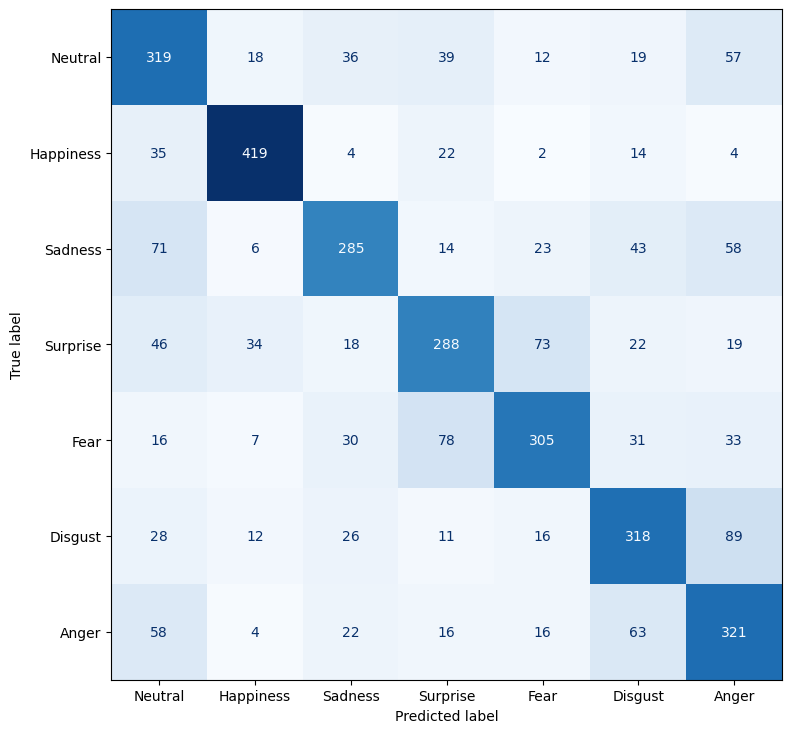

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Assuming y_true, y_pred, and labels are already defined
labels = list(class_to_idx.keys())
print(labels)

def plt_conf_matrix(y_true, y_pred, labels):
    print(y_pred.shape, y_true.shape, (y_pred == y_true).mean())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    # Create a ConfusionMatrixDisplay instance and plot it
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)  # Adjust cmap and colorbar as needed
    plt.tight_layout()
    plt.show()

# Call the function with your data
plt_conf_matrix(y_val, y_pred, labels)